Error importing pmdarima: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
Falling back to manual ARIMA parameters

First 5 rows of the dataset:
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: 0.8153688792060475
p-value: 0.991880243437641
Critical Values:
   1%, -3.4816817173418295
   5%, -2.8840418343195267
   10%, -2.578770059171598

Differenced Data (First Order):
ADF Statistic (Differenced): -2.829266824170006
p-value (Differenced): 0.05421329028382468
Critical Values (Differenced):
   1%, -3.4816817173418295
   5%, -2.8840418343195267
   10%, -2.578770059171598


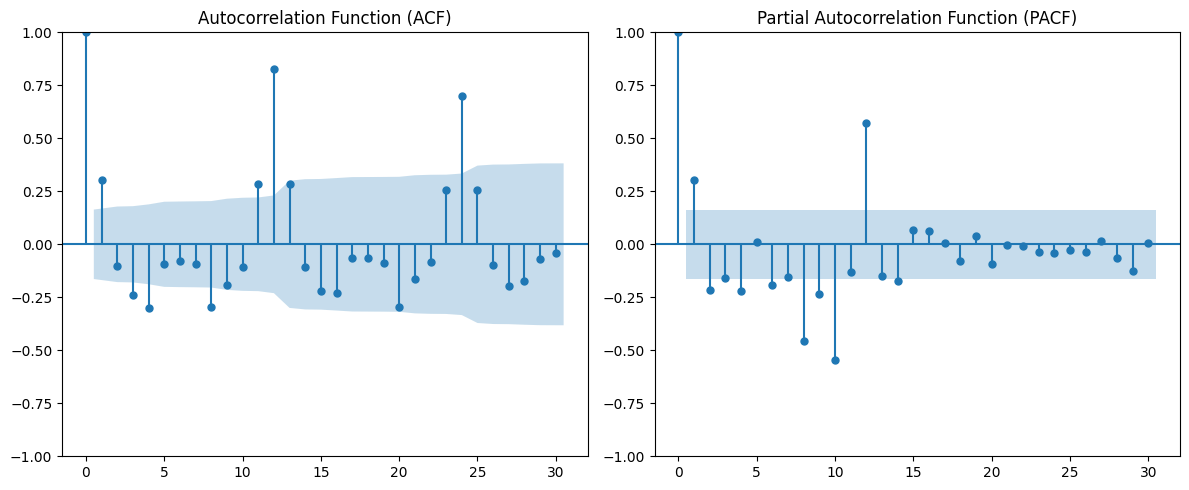


Using manual ARIMA parameters

Fitting ARIMA model with order=(2, 1, 2) and seasonal_order=(0, 1, 1, 12)

ARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             ARIMA(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                            Mon, 14 Apr 2025   AIC                           1019.935
Time:                                    12:30:15   BIC                           1037.186
Sample:                                01-01-1949   HQIC                          1026.945
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

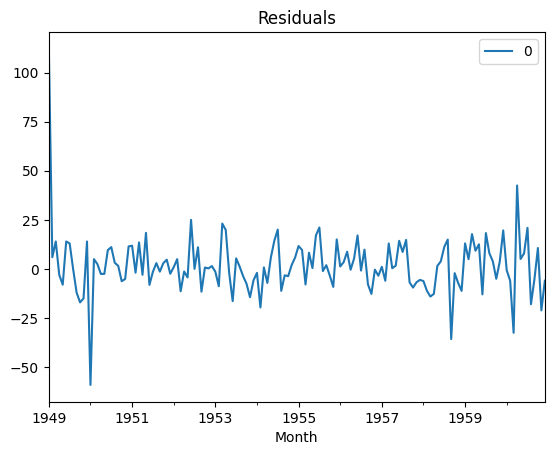

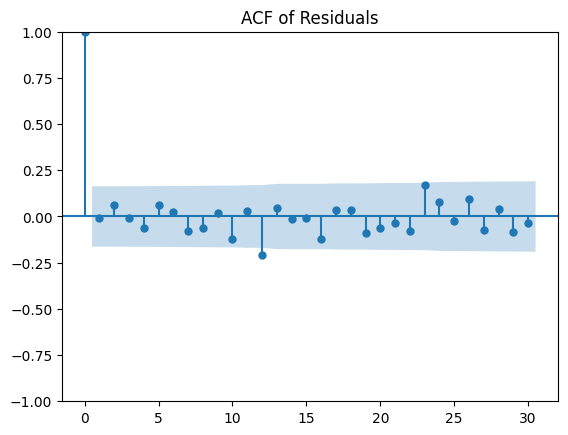

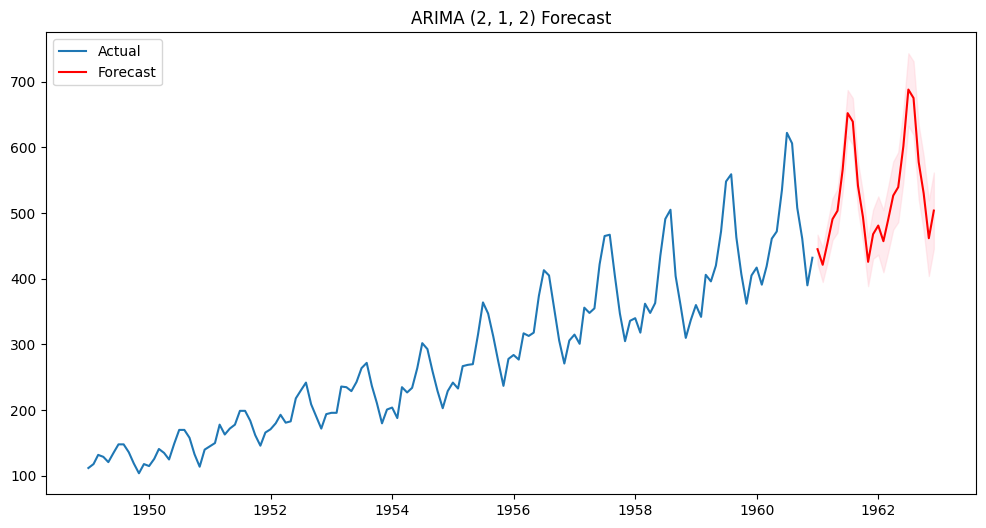


Analysis complete. Remember to complete the R comparison portion.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

try:
    from pmdarima import auto_arima
    AUTO_ARIMA_AVAILABLE = True
except ImportError:
    print("pmdarima not available, falling back to manual ARIMA parameters")
    AUTO_ARIMA_AVAILABLE = False
except ValueError as e:
    print(f"Error importing pmdarima: {e}")
    print("Falling back to manual ARIMA parameters")
    AUTO_ARIMA_AVAILABLE = False

# Load the Monthly Airline Passenger Data from CSV file
file_path = 'C:/Users/USER/Downloads/AirPassengers.csv'  # Update this path as needed
try:
    df = pd.read_csv(file_path, parse_dates=['Month'], index_col='Month')
    df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Check for stationarity using the Augmented Dickey-Fuller (ADF) test
print("\nAugmented Dickey-Fuller (ADF) Test:")
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}, {value}')

# Difference the data if not stationary
if adf_result[1] > 0.05:
    df_diff = df.diff().dropna()
    print("\nDifferenced Data (First Order):")
    adf_result_diff = adfuller(df_diff['Passengers'])
    print(f'ADF Statistic (Differenced): {adf_result_diff[0]}')
    print(f'p-value (Differenced): {adf_result_diff[1]}')
    print('Critical Values (Differenced):')
    for key, value in adf_result_diff[4].items():
        print(f'   {key}, {value}')
else:
    df_diff = df.copy()

# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(df_diff['Passengers'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(df_diff['Passengers'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# ARIMA Modeling
try:
    if AUTO_ARIMA_AVAILABLE:
        print("\nRunning auto_arima to find best parameters...")
        auto_model = auto_arima(df['Passengers'], seasonal=True, m=12, 
                              stepwise=True, trace=True, 
                              suppress_warnings=True)
        print("\nAuto ARIMA Model Summary:")
        print(auto_model.summary())
        order = auto_model.order
        seasonal_order = auto_model.seasonal_order
    else:
        # Manual parameters based on typical AirPassengers dataset
        print("\nUsing manual ARIMA parameters")
        order = (2, 1, 2)
        seasonal_order = (0, 1, 1, 12)
    
    # Fit ARIMA model
    print(f"\nFitting ARIMA model with order={order} and seasonal_order={seasonal_order}")
    model = ARIMA(df['Passengers'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    print("\nARIMA Model Summary:")
    print(model_fit.summary())
    
    # Plot diagnostics
    print("\nModel Diagnostics:")
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(title="Residuals")
    plt.show()
    
    plot_acf(residuals, lags=30, title="ACF of Residuals")
    plt.show()
    
    # Forecast
    forecast_steps = 24
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Passengers'], label='Actual')
    plt.plot(forecast_df['Forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index, 
                    forecast_df['lower Passengers'], 
                    forecast_df['upper Passengers'],
                    color='pink', alpha=0.3)
    plt.title(f'ARIMA {order} Forecast')
    plt.legend()
    plt.show()
    
except Exception as e:
    print(f"\nError during ARIMA modeling: {e}")
    print("Try adjusting the parameters or checking your data")

print("\nAnalysis complete. Remember to complete the R comparison portion.")